In [1]:
from tsplearn import *
import numpy as np 
import pandas as pd

prob_T=0.5

# Load the graph
G = EnhancedGraph(n=40, p_edges=0.162, p_triangles=prob_T, seed=0)
B1 = G.get_b1()
B2 = G.get_b2()

# Sub-sampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]
nu = B2.shape[1]
nd = B1.shape[1]
T = int(np.ceil(nu*(1-prob_T)))

# Laplacians
Lu, Ld, L = G.get_laplacians(sub_size=100)
Lu_full = G.get_laplacians(sub_size=100, full=True)
M =  L.shape[0]


# Problem and Dictionary Dimensionalities
dictionary_type="separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
P = 3 # Number of Kernels (Sub-dictionaries)
J = 2 # Polynomial order
sparsity = .1 # Sparsity percentage
K0_max = 20 #floor(M*sparsity) # Sparsity
sparsity_mode = "max"
n_search = 1500
n_sim = 10

# Data-Independent Problem Hyperparameters
K0_coll = np.arange(5, 26, 4) 
max_iter = 100 
patience = 5 
tol = 1e-7 # tolerance for Patience
lambda_ = 1e-7 # l2 multiplier
verbose = True

In [2]:
T

31

In [32]:
D_true, Y_train, Y_test, X_train, X_test, epsilon_true, c_true = generate_data(dictionary_type=dictionary_type,
                                                                                Lu=Lu,
                                                                                Ld=Ld,
                                                                                M=M,
                                                                                P=P,
                                                                                J=J,
                                                                                n_sim=n_sim,
                                                                                m_test=m_test,
                                                                                m_train=m_train,
                                                                                K0_max=K0_max,
                                                                                n_search=n_search,
                                                                                sparsity_mode=sparsity_mode,
                                                                                )

100%|██████████| 1500/1500 [02:09<00:00, 11.61it/s]


...Done! # Best Sparsity: 5


100%|██████████| 1500/1500 [02:10<00:00, 11.46it/s]


...Done! # Best Sparsity: 6


100%|██████████| 1500/1500 [02:04<00:00, 12.06it/s]


...Done! # Best Sparsity: 5


100%|██████████| 1500/1500 [02:07<00:00, 11.72it/s]


...Done! # Best Sparsity: 5


100%|██████████| 1500/1500 [02:08<00:00, 11.70it/s]


...Done! # Best Sparsity: 5


100%|██████████| 1500/1500 [02:08<00:00, 11.67it/s]


...Done! # Best Sparsity: 5


100%|██████████| 1500/1500 [02:08<00:00, 11.71it/s]


...Done! # Best Sparsity: 8


100%|██████████| 1500/1500 [02:07<00:00, 11.80it/s]


...Done! # Best Sparsity: 5


100%|██████████| 1500/1500 [02:08<00:00, 11.72it/s]


...Done! # Best Sparsity: 5


100%|██████████| 1500/1500 [02:04<00:00, 12.06it/s]

...Done! # Best Sparsity: 6


In [33]:
import os
import pickle 

name = f'top_data_T{int(prob_T*100)}'
save_var = {"D_true" : D_true,
            "Y_train" : Y_train,
            "Y_test" : Y_test,
            "X_train" : X_train,
            "X_test" : X_test,
            "epsilon_true" : epsilon_true,
            "c_true" : c_true}

PATH = os.getcwd()
DIR_PATH = f'{PATH}\\synthetic_data'
FILENAME = f'{DIR_PATH}\\{name}.pkl'

if not os.path.exists(DIR_PATH):
    os.makedirs(DIR_PATH)
    
with open(FILENAME, 'wb') as f: 
    pickle.dump(save_var, f)
f.close()

In [3]:
import os
import pickle

name = f'top_data_T{int(prob_T*100)}'
PATH = os.getcwd()
DIR_PATH = f'{PATH}\\synthetic_data'
FILENAME = f'{DIR_PATH}\\{name}.pkl'

with open(FILENAME, 'rb') as f: 
    load_data = pickle.load(f)
f.close()

D_true = load_data['D_true']
Y_train = load_data['Y_train']
Y_test = load_data['Y_test']
X_train = load_data['X_train']
X_test = load_data['X_test']
epsilon_true =  load_data['epsilon_true']
c_true = load_data['c_true']

In [13]:
import scipy.linalg as sla
import numpy as np
import numpy.linalg as la
import cvxpy as cp
from tsplearn.data_gen import *
from typing import Tuple, List, Union

def topological_dictionary_learn(Y_train: np.ndarray,
                                 Y_test: np.ndarray, 
                                 J: int, 
                                 M: int, 
                                 P: int,
                                 D0: np.ndarray, 
                                 X0: np.ndarray, 
                                 Lu: np.ndarray, 
                                 Ld: np.ndarray,
                                 dictionary_type: str, 
                                 c: float, 
                                 epsilon: float, 
                                 K0: int,
                                 lambda_: float = 1e-3, 
                                 max_iter: int = 10, 
                                 patience: int = 10,
                                 tol: float = 1e-7, 
                                 verbose: bool = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Dictionary learning algorithm implementation for sparse representations of a signal on complex regular cellular.
    The algorithm consists of an iterative alternating optimization procedure defined in two steps: the positive semi-definite programming step
    for obtaining the coefficients and dictionary based on Hodge theory, and the Orthogonal Matching Pursuit step for constructing 
    the K0-sparse solution from the dictionary found in the previous step, which best approximates the original signal.
    Args:
        Y_train (np.ndarray): Training data.
        Y_test (np.ndarray): Testing data.
        J (int): Max order of the polynomial for the single sub-dictionary.
        M (int): Number of data points (number of nodes in the data graph).
        P (int): Number of kernels (sub-dictionaries).
        D0 (np.ndarray): Initial dictionary.
        X0 (np.ndarray): Initial sparse representation.
        Lu (np.ndarray): Upper Laplacian matrix
        Ld (np.ndarray): Lower Laplacian matrix
        dictionary_type (str): Type of dictionary.
        c (float): Boundary constant from the synthetic data generation process.
        epsilon (float): Boundary constant from the synthetic data generation process.
        K0 (int): Sparsity of the signal representation.
        lambda_ (float, optional): Regularization parameter. Defaults to 1e-3.
        max_iter (int, optional): Maximum number of iterations. Defaults to 10.
        patience (int, optional): Patience for early stopping. Defaults to 10.
        tol (float, optional): Tolerance value. Defaults to 1e-s.
        verbose (int, optional): Verbosity level. Defaults to 0.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
         minimum training error, minimum testing error, optimal coefficients, optimal testing sparse representation, and optimal training sparse representation.
    """

    # Define hyperparameters
    min_error_train_norm, min_error_test_norm = 1e20, 1e20
    m_test, m_train = Y_test.shape[1], Y_train.shape[1]
    iter_, pat_iter = 1, 0
    history = []

    if dictionary_type != "fourier":
        if dictionary_type=="joint":
            Lj, _, _ = compute_Lj_and_lambdaj(Lu + Ld, J)
        elif dictionary_type=="edge_laplacian":
            Lj, _, _ = compute_Lj_and_lambdaj(Ld, J)
        elif dictionary_type=="separated":
            Luj, _, _ = compute_Lj_and_lambdaj(Lu, J, separated=True)
            Ldj, _, _ = compute_Lj_and_lambdaj(Ld, J, separated=True)

        # Init the dictionary and the sparse representation 
        D_coll = [cp.Constant(D0[:,(M*i):(M*(i+1))]) for i in range(P)]
        Y = cp.Constant(Y_train)
        X_train = X0
        
        while pat_iter < patience and iter_ <= max_iter:
            
            # SDP Step
            # Init constants and parameters
            D_coll = [cp.Constant(np.zeros((M, M))) for i in range(P)] 
            Dsum = cp.Constant(np.zeros((M, M)))
            X = cp.Constant(X_train)
            I = cp.Constant(np.eye(M))
            
            # Define the objective function
            if dictionary_type in ["joint", "edge_laplacian"]:
                # Init the variables
                h = cp.Variable((P, J))
                hI = cp.Variable((P, 1))
                for i in range(0,P):
                    tmp =  cp.Constant(np.zeros((M, M)))
                    for j in range(0,J):
                        tmp += (cp.Constant(Lj[j, :, :]) * h[i,j])
                    tmp += (I*hI[i])
                    D_coll[i] = tmp
                    Dsum += tmp
                D = cp.hstack([D_coll[i]for i in range(P)])
                term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                term2 = cp.square(cp.norm(h, 'fro')*lambda_)
                term3 = cp.square(cp.norm(hI, 'fro')*lambda_)
                obj = cp.Minimize(term1 + term2 + term3)

            else:
                # Init the variables
                hI = cp.Variable((P, J))
                hS = cp.Variable((P, J))
                hH = cp.Variable((P, 1))
                for i in range(0,P):
                    tmp =  cp.Constant(np.zeros((M, M)))
                    for j in range(0,J):
                        tmp += ((cp.Constant(Luj[j, :, :])*hS[i,j]) + (cp.Constant(Ldj[j, :, :])*hI[i,j]))
                    tmp += (I*hH[i])
                    D_coll[i] = tmp
                    Dsum += tmp
                D = cp.hstack([D_coll[i]for i in range(P)])
                
                term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                term2 = cp.square(cp.norm(hI, 'fro')*lambda_)
                term3 = cp.square(cp.norm(hS, 'fro')*lambda_)
                term4 = cp.square(cp.norm(hH, 'fro')*lambda_)
                obj = cp.Minimize(term1 + term2 + term3 + term4)

            # Define the constraints
            constraints = [D_coll[i] >> 0 for i in range(P)] + \
                            [(cp.multiply(c, I) - D_coll[i]) >> 0 for i in range(P)] + \
                            [(Dsum - cp.multiply((c - epsilon), I)) >> 0, (cp.multiply((c + epsilon), I) - Dsum) >> 0]

            prob = cp.Problem(obj, constraints)
            prob.solve(solver=cp.MOSEK, verbose=False)
            # Update the dictionary
            D = D.value

            # OMP Step
            dd = la.norm(D, axis=0)
            W = np.diag(1. / dd)
            Domp = D @ W
            X_train = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_train)
            X_test = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_test)
            # Normalization
            X_train = W @ X_train
            X_test = W @ X_test

            # Error Updating
            error_train_norm = (1/m_train)* np.sum(la.norm(Y_train - (D @ X_train), axis=0)**2 /
                                    la.norm(Y_train, axis=0)**2)
            error_test_norm = (1/m_test)* np.sum(la.norm(Y_test - (D @ X_test), axis=0)**2 /
                                    la.norm(Y_test, axis=0)**2)

            history.append(error_test_norm)
            
            # Error Storing
            if (error_train_norm < min_error_train_norm) and (abs(error_train_norm) > np.finfo(float).eps) and (abs(error_train_norm - min_error_train_norm) > tol):
                X_opt_train = X_train
                min_error_train_norm = error_train_norm

            if (error_test_norm < min_error_test_norm) and (abs(error_test_norm) > np.finfo(float).eps) and (abs(error_test_norm - min_error_test_norm) > tol):
                h_opt = h.value if dictionary_type in ["joint", "edge_laplacian"] else [hS.value, hI.value, hH.value]
                D_opt = D
                X_opt_test = X_test
                min_error_test_norm = error_test_norm
                pat_iter = 0

                if verbose == 1:
                    print("New Best Test Error:", min_error_test_norm)
            else:
                pat_iter += 1

            # print("-"*100)
            # print(f'Iter: {iter_}')
            # print()
            # print(f'hH.shape: {hH.shape}')
            # print(f'hH: {hH.value}')
            # print()
            # print(f'hS.shape: {hS.shape}')
            # print(f'hS: {hS.value}')
            # print()
            # print(f'hI.shape: {hI.shape}')
            # print(f'hI: {hI.value}')
            # print()
            # print(f'test error: {error_test_norm}')
            # print()
            # print("-"*100)

            iter_ += 1
    
    else:

        # Fourier Dictionary Benchmark
        L = Lu + Ld
        _, D_opt = sla.eigh(L)
        dd = la.norm(D_opt, axis=0)
        W = np.diag(1./dd)  
        D_opt = D_opt / la.norm(D_opt)
        Domp = D_opt@W
        X_opt_train = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp.real, col=x), axis=0, arr=Y_train)
        X_opt_test = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp.real, col=x), axis=0, arr=Y_test)
        X_opt_train = W @ X_opt_train
        X_opt_test = W @ X_opt_test

        # Error Updating
        min_error_train_norm = (1/m_train)* np.sum(la.norm(Y_train - (D_opt @ X_opt_train), axis=0)**2 /
                                la.norm(Y_train, axis=0)**2)
        min_error_test_norm = (1/m_test)* np.sum(la.norm(Y_test - (D_opt @ X_opt_test), axis=0)**2 /
                                la.norm(Y_test, axis=0)**2)
        h_opt = 0
        
    return min_error_train_norm, min_error_test_norm, h_opt, X_opt_test, X_opt_train, D_opt, Ldj, history

In [5]:
s = 8

In [9]:
c = c_true[s]  
epsilon = epsilon_true[s] 
k0 = K0_coll[1]

D0, X0 = init_dict(Lu, Ld, P, J, Y_train[:, :, s], k0, dictionary_type, c, epsilon, only="only_X")

min_error_train_norm, min_error_test_norm, h_opt, X_opt_test, X_opt_train = topological_dictionary_learn(Y_train[:,:,s], Y_test[:,:,s],
                                                                                                                        J, M, P, D0, X0, Lu_full, Ld, "separated",
                                                                                                                        c, epsilon, k0, lambda_, max_iter,
                                                                                                                        patience, tol)

In [9]:
h_opt

[array([[-1.21262049e-05,  2.42427963e-04],
        [ 3.11200292e-01,  7.49673332e-02],
        [ 1.90419773e-04,  2.02344903e-04]]),
 array([[-2.39019477e-06,  2.34529850e-06],
        [ 6.87016629e-02,  7.66459275e-02],
        [-1.58366439e-05,  4.37043735e-05]]),
 array([[1.09120630e-05],
        [1.48800998e-01],
        [7.78454510e-07]])]

In [14]:
def sparse_transform(D, K0, Y_test, Y_train=None):

    # OMP Step
    dd = la.norm(D, axis=0)
    W = np.diag(1. / dd)
    Domp = D @ W
    X_test = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_test)
    # Normalization
    X_test = W @ X_test

    # Same for the training set
    if Y_train != None:
        X_train = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_train)
        X_train = W @ X_train

        return X_test, X_train
    
    return X_test

def nmse(D, X, Y, m):
    return (1/m)* np.sum(la.norm(Y - (D @ X), axis=0)**2 /la.norm(Y, axis=0)**2)

In [15]:
# global B2, h_opt, J

# Ldk,_,_= compute_Lj_and_lambdaj(Ld, J)


def indicator_matrix(row):
    tmp = row.sigma.copy()
    tmp[row.idx] = 0
    return np.diag(tmp)

def compute_Luj(row, b2, J):
    Lu = b2 @ row.sigma @ b2.T
    Luj = np.array([la.matrix_power(Lu, i) for i in range(1, J + 1)])
    return Luj


def learn_upper_laplacian(Y_train: np.ndarray,
                          Y_test: np.ndarray, 
                          J: int, 
                          M: int, 
                          P: int,
                          Lu: np.ndarray, 
                          Ld: np.ndarray,
                          dictionary_type: str, 
                          c: float, 
                          epsilon: float, 
                          K0: int,
                          B2: np.ndarray,
                          history: List[np.ndarray] = [],
                          filter: np.ndarray = 1,
                          current_min: float = None,
                          h_opt: np.ndarray = None,
                          lambda_: float = 1e-3, 
                          max_iter: int = 10, 
                          patience: int = 10,
                          tol: float = 1e-7, 
                          verbose: bool = False):
    
    # assert np.all(current_min!=B2), "You must provide the edge-triangle incidence matrix B2."

    # Check if we are executing the first recursive iteration
    if current_min == None:
        current_min = np.inf
        T = B2.shape[1]
        filter = np.ones(T)


    D0, X0 = init_dict(Lu=Lu,
                        Ld=Ld,
                        P=P,
                        J=J,
                        Y_train=Y_train,
                        K0=K0,
                        dictionary_type=dictionary_type,
                        c=c,
                        epsilon=epsilon,
                        h=h_opt,
                        only="only_X")

    _, min_error_test, h_opt, X_opt_test, _, D_opt, Ldj, hist = topological_dictionary_learn(Y_train=Y_train,
                                                                                    Y_test=Y_test,
                                                                                    J=J,
                                                                                    M=M,
                                                                                    P=P,
                                                                                    D0=D0,
                                                                                    X0=X0,
                                                                                    Lu=Lu,
                                                                                    Ld=Ld,
                                                                                    dictionary_type=dictionary_type,
                                                                                    c=c,
                                                                                    epsilon=epsilon,
                                                                                    K0=K0,
                                                                                    lambda_=lambda_,
                                                                                    max_iter=max_iter,
                                                                                    patience=patience,
                                                                                    tol=tol)
    history.append(hist)
    search_space = np.where(filter == 1)    
    sigmas = pd.DataFrame({"idx": search_space[0]})

    sigmas["sigma"] = sigmas.idx.apply(lambda x: filter)
    sigmas["sigma"] = sigmas.apply(lambda x: indicator_matrix(x), axis=1)
    sigmas["Luj"] = sigmas.apply(lambda x: compute_Luj(x, B2, J), axis=1)
    sigmas["D"] = sigmas.apply(lambda x: generate_dictionary(h_opt, P, x.Luj, Ldj), axis=1)
    sigmas["X"] = sigmas.D.apply(lambda x: sparse_transform(x, k0, Y_test))
    sigmas["NMSE"] = sigmas.apply(lambda x: nmse(x.D, x.X, Y_test, m_test), axis=1)
    
    candidate_error = sigmas.NMSE.min()
    idx_min = sigmas.NMSE.idxmin()

    if candidate_error < min_error_test:
        S = sigmas.sigma[idx_min]
        Lu_new = B2 @ S @ B2.T
        current_min = candidate_error
        filter = np.diagonal(S)

        if verbose:
            print(f'Removing 1 triangle from topology... \n ... New min test error: {current_min} !')

        return learn_upper_laplacian(Y_train=Y_train,
                                    Y_test=Y_test,
                                    J =J,
                                    M=M,
                                    P=P,
                                    Lu=Lu_new,
                                    Ld=Ld,
                                    dictionary_type=dictionary_type,
                                    c=c,
                                    epsilon=epsilon,
                                    K0=K0,
                                    h_opt=h_opt,
                                    history=history,
                                    filter=filter,
                                    current_min=current_min,
                                    B2=B2,
                                    lambda_=lambda_,
                                    max_iter=max_iter,
                                    patience=patience,
                                    tol=tol,
                                    verbose=verbose)

    return min_error_test, history, Lu, h_opt, X_opt_test, D_opt


In [16]:
min_error_test, history, Lu, h_opt, X_opt_test, D_opt = learn_upper_laplacian(B2=B2,
                                                                            Y_train=Y_train[:,:,s],
                                                                            Y_test=Y_test[:,:,s],
                                                                            J=J,
                                                                            M=M,
                                                                            P=P,
                                                                            Lu=Lu_full,
                                                                            Ld=Ld,
                                                                            dictionary_type=dictionary_type,
                                                                            c=c,
                                                                            epsilon=epsilon,
                                                                            K0=k0,
                                                                            lambda_=lambda_,
                                                                            max_iter=max_iter,
                                                                            patience=patience,
                                                                            tol=tol,
                                                                            verbose=verbose)

Removing 1 triangle from topology... 
 ... New min test error: 0.04186229999386083 !
Removing 1 triangle from topology... 
 ... New min test error: 0.03953748791677277 !
Removing 1 triangle from topology... 
 ... New min test error: 0.03726287089805516 !
Removing 1 triangle from topology... 
 ... New min test error: 0.03606642188678121 !
Removing 1 triangle from topology... 
 ... New min test error: 0.0344642614097185 !
Removing 1 triangle from topology... 
 ... New min test error: 0.03296781959164594 !
Removing 1 triangle from topology... 
 ... New min test error: 0.03144162986914475 !
Removing 1 triangle from topology... 
 ... New min test error: 0.030511556010098462 !
Removing 1 triangle from topology... 
 ... New min test error: 0.02956670100833696 !
Removing 1 triangle from topology... 
 ... New min test error: 0.027718567545433687 !
Removing 1 triangle from topology... 
 ... New min test error: 0.026650691909113074 !
Removing 1 triangle from topology... 
 ... New min test error: 

In [15]:
B2.shape

(100, 62)

In [125]:
len(history)

25

In [22]:
62-25

37

In [105]:
for h in history:

    print(len(h))

33
13
16
6
6
6
6
13
7
10
6
6
6
6
7
6
17
6
8
6
8
6
6
12
7


In [47]:
change_points[:-1]

[32,
 45,
 61,
 67,
 73,
 79,
 85,
 98,
 105,
 115,
 121,
 127,
 133,
 139,
 146,
 152,
 169,
 175,
 183,
 189,
 197,
 203,
 209,
 221]

In [137]:
history

[[0.6866614301187433,
  0.27921625054094434,
  0.19319500477041537,
  0.13553820115757428,
  0.19821985384435756,
  0.09182395311147089,
  0.07925233818349363,
  0.07318508589452748,
  0.06842377619328936,
  0.06650563817032361,
  0.06466094844350496,
  0.06308288209147109,
  0.06167974335511568,
  0.060725414726472575,
  0.05873927921786818,
  0.057099200554634744,
  0.05635318794571045,
  0.055531203087046614,
  0.053977476469241684,
  0.05299657067968373,
  0.051146636187054395,
  0.05028999821130584,
  0.04941686724416308,
  0.04733835483535007,
  0.04603861664017374,
  0.04545561630733617,
  0.044776722433979066,
  0.044476144920566923,
  0.044540408167708705,
  0.045109998263051926,
  0.04488842387589531,
  0.044800949879748565,
  0.044484533588271286],
 [0.04186641769845272,
  0.04226338361658083,
  0.04245460429351458,
  0.042305828745048665,
  0.04185076060290316,
  0.041826010208553484,
  0.041637267556128815,
  0.04144953394413697,
  0.04150639815849738,
  0.0415140998495565

In [49]:
end_iter = -1
change_points = []

for h in history:
    end_iter += len(h)
    change_points.append(end_iter)

change_points = np.array(change_points[:-1])

In [41]:
his.shape

(229,)

In [33]:
his[his==-np.inf]= np.nan

In [103]:
burn_in_iter

7

In [121]:
burn_in = 0
end_iter = -1
change_points = []
burn_in_iter = 0

for i,h in enumerate(history):
    if i == 0:
        burn_in_iter=int(np.ceil(burn_in*len(h)))

    end_iter += len(h)
    change_points.append(end_iter)

change_points = np.array(change_points[:-1])

In [119]:
change_points

array([ 32,  45,  61,  67,  73,  79,  85,  98, 105, 115, 121, 127, 133,
       139, 146, 152, 169, 175, 183, 189, 197, 203, 209, 221])

In [123]:
his.shape

(194,)

In [124]:
burn_in_iter

7

In [160]:
x=np.arange(burn_in_iter, (len(his)+burn_in_iter))

In [161]:
x

array([ 22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 20

In [211]:
burn_in = 0.65
start_iter = 0
end_iter = 0
change_points = []
burn_in_iter = 0

his=[]
xx = []
for i,h in enumerate(history):
    if i == 0:
        burn_in_iter=int(np.ceil(burn_in*len(h)))
    his+=h
    end_iter += len(h)-1
    print(end_iter)
    tmp = range(start_iter, end_iter+1)
    xx += tmp
    start_iter = end_iter
    change_points.append(end_iter)

change_points = np.array(change_points[:-1])

32
44
59
64
69
74
79
91
97
106
111
116
121
126
132
137
153
158
165
170
177
182
187
198
204


In [202]:
list(tmp)

[221, 222, 223, 224, 225, 226, 227, 228]

In [212]:
xx

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 59,
 60,
 61,
 62,
 63,
 64,
 64,
 65,
 66,
 67,
 68,
 69,
 69,
 70,
 71,
 72,
 73,
 74,
 74,
 75,
 76,
 77,
 78,
 79,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 106,
 107,
 108,
 109,
 110,
 111,
 111,
 112,
 113,
 114,
 115,
 116,
 116,
 117,
 118,
 119,
 120,
 121,
 121,
 122,
 123,
 124,
 125,
 126,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 132,
 133,
 134,
 135,
 136,
 137,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 153,
 154,
 155,
 156,
 157,
 158,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 165,
 166,
 16

In [218]:
change_points[-1] + len(h)

205

In [213]:
len(xx)

229

In [215]:
df = pd.DataFrame({'y':his, 
                   'x':xx})

In [235]:
change_points_y = np.array([his[chp-1] for chp in change_points])

In [236]:
change_points_y

array([0.04480095, 0.04167403, 0.0395194 , 0.03773006, 0.0364799 ,
       0.0370185 , 0.03483648, 0.03202839, 0.03172043, 0.03067937,
       0.02884405, 0.02962364, 0.02830185, 0.02794837, 0.02774291,
       0.02531667, 0.02470142, 0.02295802, 0.02208594, 0.02326929,
       0.02252672, 0.02320206, 0.02331804, 0.02283196])

In [268]:
plt_data

,y,x
0,0.049417,22
1,0.047338,23
2,0.046039,24
3,0.045456,25
4,0.044777,26
...,...,...
202,0.021282,200
203,0.021242,201
204,0.021347,202
205,0.021352,203


In [282]:
change_points_y2.shape

AttributeError: 'list' object has no attribute 'shape'

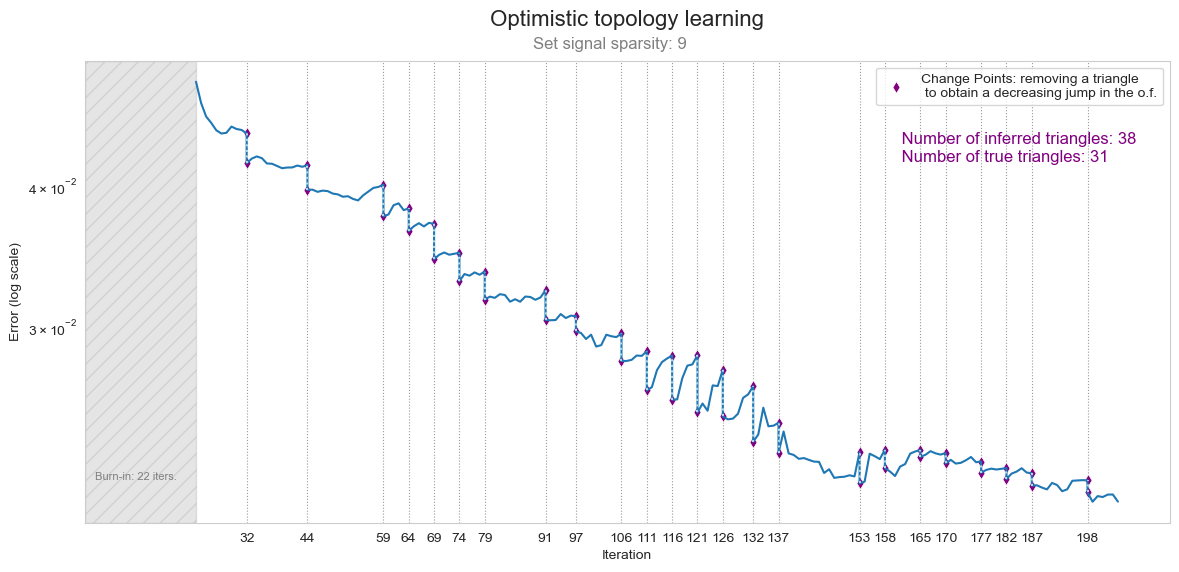

In [360]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

burn_in = 0.65
start_iter = 0
end_iter = 0
change_points = []
change_points_y1 = []
change_points_y2 = []
burn_in_iter = 0
his=[]
xx = []
for i,h in enumerate(history):
    if i == 0:
        burn_in_iter=int(np.ceil(burn_in*len(h)))
    his+=h
    end_iter += len(h)-1
    tmp = range(start_iter, end_iter+1)
    xx += tmp
    start_iter = end_iter
    change_points.append(end_iter)
    change_points_y1.append(h[-1])
    change_points_y2.append(h[0])

plt_data = pd.DataFrame({'y':his[burn_in_iter:], 
                   'x':xx[burn_in_iter:]})

change_points = np.array(change_points[:-1])
change_points_y1 = np.array(change_points_y1[:-1])
change_points_y2 = np.array(change_points_y2[1:])
# change_points_y = plt_data[plt_data['x'].isin(change_points)].y.to_numpy()[np.arange(0, len(change_points), 1)]

plt.figure(figsize=(14, 6))
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

my_plt = sns.lineplot(x=plt_data['x'],y=plt_data['y'], estimator=None, sort=False)

# Change-points
sns.scatterplot(x=np.hstack([change_points, change_points]),
                 y=np.hstack([change_points_y1, change_points_y2]),
                 label='Change Points: removing a triangle \n to obtain a decreasing jump in the o.f.',
                 color='purple', marker='d')

plt.vlines(x=change_points, color='lightblue', linestyle='dotted', 
           ymax=change_points_y1, ymin=change_points_y2)

# Burn-in area
plt.axvspan(0, burn_in_iter, color='grey', alpha=0.2, hatch='//')

my_plt.set_title(f'Optimistic topology learning',fontsize=16, pad=25)
plt.suptitle(f'Set signal sparsity: {k0}', fontsize=12, color='gray', x=0.5, y=0.92)
plt.text(y=2.2e-2, x=2, s=f'Burn-in: {burn_in_iter} iters.', fontsize=8, color='gray')
plt.text(s=f' Number of inferred triangles: {nu - change_points.shape[0]} \n Number of true triangles: {T}',
         y=4.2e-2, x=len(his)*0.7, fontsize=12, color='purple')
my_plt.set_xlabel('Iteration')
my_plt.set_ylabel('Error (log scale)')
plt.xticks(change_points)
plt.yticks([])
plt.xlim(left=0)
plt.yscale('log')
plt.show() 

In [265]:
plt_data[plt_data['x'].isin(change_points)].y.to_numpy()[np.arange(0, len(change_points), 1)].shape

(48,)

In [263]:
change_points

array([ 32,  44,  59,  64,  69,  74,  79,  91,  97, 106, 111, 116, 121,
       126, 132, 137, 153, 158, 165, 170, 177, 182, 187, 198])

In [247]:
plt_data.iloc[change_points-burn_in_iter]

,y,x,id
10,0.044485,32,10
22,0.041568,43,22
37,0.039818,57,37
42,0.038444,61,42
47,0.036833,65,47
52,0.034442,69,52
57,0.034903,74,57
69,0.031597,84,69
75,0.031869,90,75
84,0.029756,97,84


In [252]:
plt_data[plt_data.x in change_points]

C:\Users\engri\AppData\Local\Temp\ipykernel_19960\1539062186.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  plt_data[plt_data.x in change_points]


ValueError: ('Lengths must match to compare', (207,), (24,))

In [254]:
44- burn_in_iter

22

In [248]:
plt_data.iloc[range(32-burn_in_iter, 70-burn_in_iter)]

,y,x,id
10,0.044485,32,10
11,0.041866,32,11
12,0.042263,33,12
13,0.042455,34,13
14,0.042306,35,14
15,0.041851,36,15
16,0.041826,37,16
17,0.041637,38,17
18,0.041450,39,18
19,0.041506,40,19


In [94]:
change_points

array([ 15,  28,  44,  50,  56,  62,  68,  81,  88,  98, 104, 110, 116,
       122, 129, 135, 152, 158, 166, 172, 180, 186, 192, 204])

In [93]:
his[change_points]

array([0.0570992 , 0.04454041, 0.04156801, 0.03956314, 0.03882176,
       0.0375909 , 0.0364799 , 0.03342532, 0.03184716, 0.03233935,
       0.03071394, 0.02884405, 0.02800928, 0.02638414, 0.02590795,
       0.02568881, 0.02470142, 0.02299325, 0.02213628, 0.02319806,
       0.02271486, 0.02331804, 0.02273674, 0.02202893])

In [16]:
62- 25

37

In [26]:
history[0][-1]

0.044476144920566923

In [152]:
sigmas.NMSE.idxmin()

37

In [10]:
min_error_test_norm

0.04299118989648461

In [153]:
sigmas.NMSE.min()

0.04186229999386083

In [83]:
Luk_full.shape

(2, 100, 100)

(2, 100, 100)

In [87]:
sigmas.D[T] == D_opt

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [66]:
sigmas.X[T-3].shape

(100, 80)